<a href="https://colab.research.google.com/github/nay-uku/studia/blob/main/Natural%20language%20processing/z2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Utworzyć korpus dokumentów na podstawie 5-10 książek pobranych ze strony Wolne Lektury: https://wolnelektury.pl/

2. Dla każdej z pozycji zwizualizować:  

a) częstość występowania klas gramatycznych

b) częstość występowania części mowy

3. Na podstawie korpusu zbudowanego   z 5 dowolnych książek ściągniętych ze strony Wolne Lektury wyznaczyć i zwizualizować częstość występowania rzeczowników sprowadzonych do form podstawowych.

4.  Na podstawie częstości wyznaczonych powyżej  zbudować macierz tfidf, wyłącznie w oparciu o rzeczowniki w formie podstawowej i każdą pozycję zwizualizować w postaci chmury tagów (wordcloud).

5. Podać kilka przykładów  niejednoznaczności znaczeniowej  występujacej w tekstach oraz przyjęty sposób ich rozwiązania 

6*. W wybranej lekturze znaleźć 5  rzeczowników występujących w formie podmiotów oraz pokazać z jakimi czasownikami się łączą  w związku podmiotu z orzeczeniem.

In [ ]:
# Przygotowanie środowiska, komendy linux
# instalacja Morfeusza 2
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2


# instalacja spaCy

!python3 -m pip install spacy

# 1. instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

# 2. instalacja oficjalnego modelu spaCy
!python3 -m spacy download pl_core_news_lg

# dodatkowe zależności:
!python3 -m pip install tqdm
!python3 -m pip install networkx

In [ ]:
!curl https://wolnelektury.pl/media/book/txt/zwierzeta-ludzie-bogowie.txt > 'Zwierzeta, ludzie, bogowie.txt'
!curl https://wolnelektury.pl/media/book/txt/zemsta.txt > Zemsta.txt
!curl https://wolnelektury.pl/media/book/txt/platon-panstwo.txt > Panstwo.txt
!curl https://wolnelektury.pl/media/book/txt/ksiega-dzungli.txt > 'Ksiega dzungli.txt'
!curl https://wolnelektury.pl/media/book/txt/rozmyslania-marek-aureliusz.txt > Rozmyslania.txt

import glob
books = glob.glob('*.txt')
print(books)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  540k  100  540k    0     0   416k      0  0:00:01  0:00:01 --:--:--  416k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   99k  100   99k    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  992k  100  992k    0     0   846k      0  0:00:01  0:00:01 --:--:--  847k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  314k  100  314k    0     0   333k      0 --:--:-- --:--:-- --:--:--  332k
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
### PYTHON 3
# ładowanie modelu
import spacy
import requests

nlp = spacy.load("pl_spacy_model_morfeusz") # IPI PAN
# nlp = spacy.load("pl_core_news_lg") # OFICJALNY

In [ ]:
# 1. Utworzyć korpus dokumentów na podstawie
# 5-10 książek pobranych ze strony Wolne Lektury: https://wolnelektury.pl/
corpus = []
for i in range(len(books)):
  with open(books[i],'r') as f:
    raw = f.read()
    split = raw.split()
    doc = nlp(raw) # tokenizacja
    corpus.append(doc)
corpus

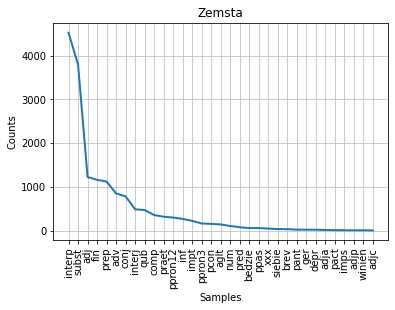

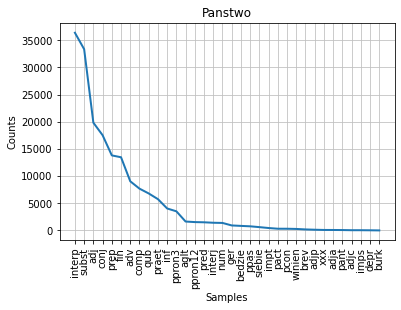

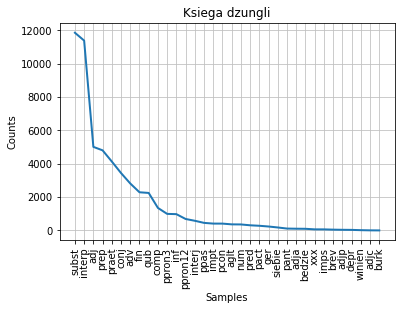

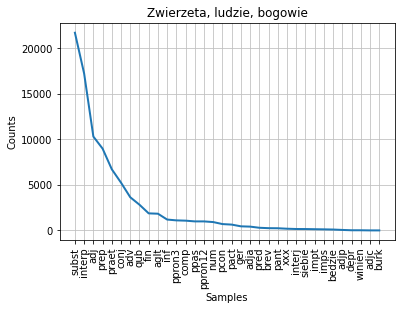

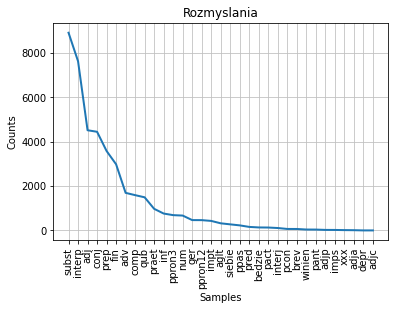

In [ ]:
# 2a) częstość występowania klas gramatycznych dla każdej pozycji
import nltk
for doc in corpus:
  TAG_count = doc.count_by(spacy.attrs.TAG) # słownik
  dict_keys = list(TAG_count.keys()) # lista numerów TAG
  for i in range(len(TAG_count)):
    # Zamiana numeru TAG na jego nazwę w słowniku
    TAG_count[doc.vocab[dict_keys[i]].text] = TAG_count.pop(dict_keys[i])
  freq = nltk.FreqDist(TAG_count)
  freq.plot(cumulative=False, title=books[corpus.index(doc)][:-4])

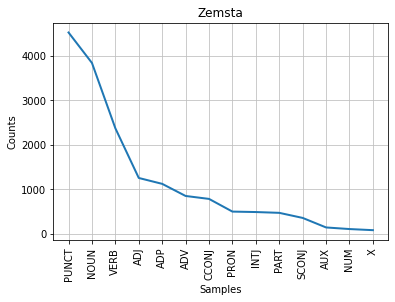

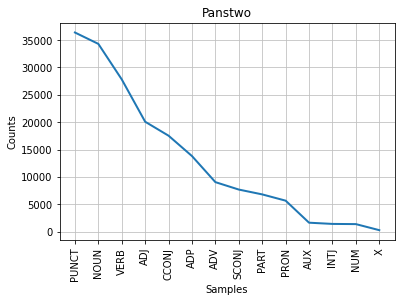

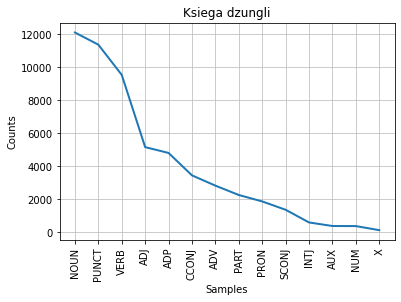

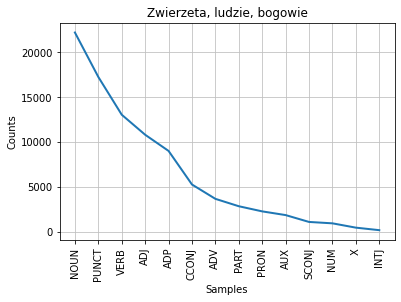

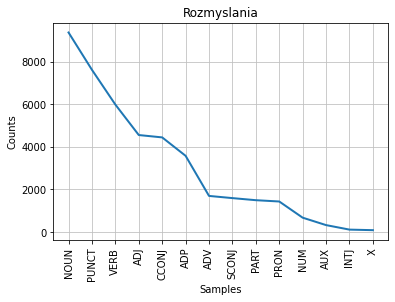

In [ ]:
# 2b) częstość występowania części mowy dla każdej pozycji
for doc in corpus:
  POS_count = doc.count_by(spacy.attrs.POS)
  dict_keys = list(POS_count.keys())
  for i in range(len(POS_count)):
    POS_count[doc.vocab[dict_keys[i]].text] = POS_count.pop(dict_keys[i])
  freq = nltk.FreqDist(POS_count)
  freq.plot(cumulative=False, title=books[corpus.index(doc)][:-4])

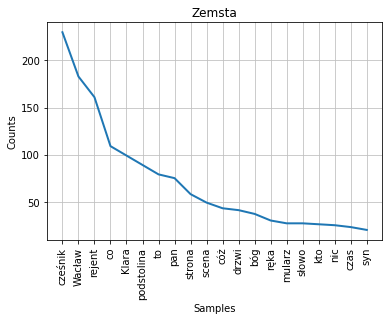

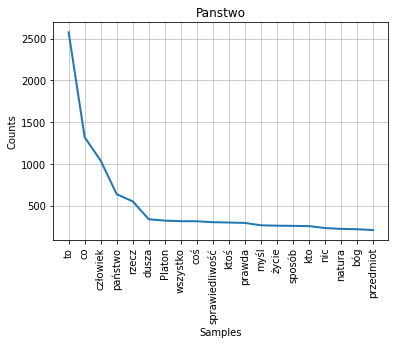

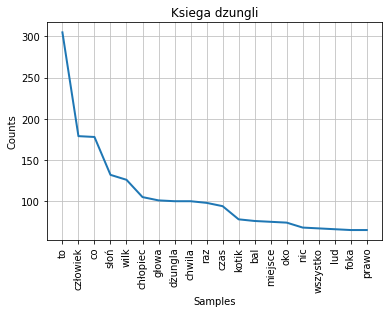

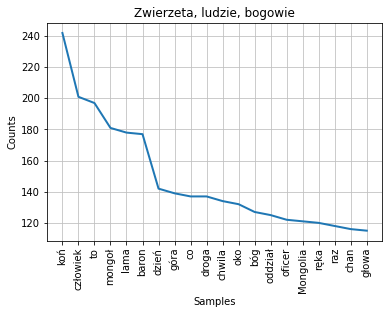

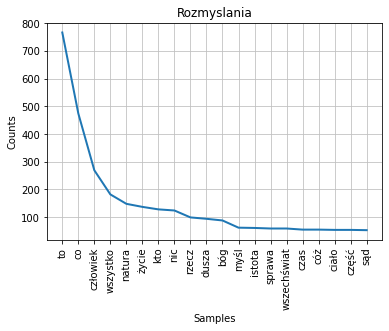

In [ ]:
# 3. Na podstawie korpusu zbudowanego z 5 dowolnych książek ściągniętych ze strony
# Wolne Lektury wyznaczyć i zwizualizować częstość występowania rzeczowników
# sprowadzonych do form podstawowych.
NOUN_corpus = [] # korpus rzeczowników
for doc in corpus:
  NOUN_lemma_count = {}
  for token in doc:
    if token.pos_ == "NOUN": # jeżeli rzeczownik
      if token.lemma_ in NOUN_lemma_count: # rozbuduj słownik o lemat
        NOUN_lemma_count[token.lemma_] += 1
      else:
        NOUN_lemma_count[token.lemma_] = 1    
  freq = nltk.FreqDist(NOUN_lemma_count)
  NOUN_corpus.append(freq)
  freq.plot(20, cumulative=False, title=books[corpus.index(doc)][:-4])

In [ ]:
# 4. Na podstawie częstości wyznaczonych powyżej zbudować macierz tfidf,
# wyłącznie w oparciu o rzeczowniki w formie podstawowej i każdą pozycję
# zwizualizować w postaci chmury tagów (wordcloud).
import pandas as pd
import sklearn as sk
import math

def computeTF(wordDict):
    tfDict = {}
    N = sum(wordDict.values()) # suma liczby słów 
    for word, count in wordDict.items():
        tfDict[word] = count/float(N)
    return tfDict

tf_list = []
for i in range(len(NOUN_corpus)):
  tf_list.append(computeTF(NOUN_corpus[i])) # TF lista słowników słowo : częstość
# tf_df = pd.DataFrame(tf_list) # TF do wizualizacji

In [ ]:
def computeIDF(docList):
  idfDict = {}
  N = len(docList)
  # Wszystkie wyrazy z każdej książki
  all_keys = set().union(*(d.keys() for d in docList))
  idfDict = dict.fromkeys(all_keys, 0)
  for doc in docList:
    for word, val in doc.items():
      if val > 0:
        idfDict[word] += 1
  
  for word, val in idfDict.items():
    idfDict[word] = math.log10(N / float(val))
      
  return idfDict
idf = computeIDF(tf_list)

In [ ]:
def computeTFIDF(tfBow, idf):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idf[word]
    return tfidf
tfidf_list = []
for i in range(len(books)):
  tfidf_list.append(computeTFIDF(tf_list[i], idf))
tfidf = pd.DataFrame(tfidf_list, index=[book[:-4] for book in books])
tfidf

,Aleksander,Fredro,Zemsta,ISBN,nic,wąż,Anda,Maks,Osoba,cześnik,Klara,synowica,rejent,milczek,Wacław,syn,podstolina,marszałek,Śmigalski,dworzanin,Perełka,kuchmistrz,mularz,hajduk,pachołek,scena,wieś,akt,pokój,zamek,drzwi,prawo,środek,stół,krzesło,gitara,ściana,żupan,pas,szlafmyca,...,zrosnąć,dopełnić,wytrwać,sztylet,wszechwładczyni,popełniać,męskość,zauważyć,przezwyciężyć,lamia,ksantypa,oznaczyć,Grono,objawić,okrywa,łupina,nieczystość,dociekanie,prawować,ominąć,urządzić,prawa,przypadkowość,przebaczyć,przypuścić,podejrzliwość,począć,rozliczność,Lupus,baja,Tyberiusz,Rufus,ciążyć,uczcić,wszechdusza,martwica,pretor,marka,serwis,zbiórka
Zemsta,0.0,0.000547,0.000182,0.0,0.0,0.000025,0.000182,0.000182,0.000182,0.041909,0.018039,0.000182,0.029336,0.001275,0.033345,0.000505,0.016217,0.000104,0.002187,0.000311,0.000547,0.000182,0.00492,0.000911,0.000729,0.0,0.0,0.000347,0.0,0.000347,0.0,0.0,0.0,0.0,0.000463,0.000547,0.000076,0.000182,0.000076,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panstwo,0.0,NaN,NaN,0.0,0.0,0.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000013,0.0,0.000006,0.0,0.0,0.0,0.0,0.000006,NaN,0.000011,NaN,0.000003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ksiega dzungli,0.0,NaN,NaN,0.0,0.0,0.000440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.000120,NaN,0.000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Zwierzeta, ludzie, bogowie",0.0,NaN,NaN,0.0,0.0,0.000039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000100,NaN,0.000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.000010,0.0,0.0,0.0,0.0,0.000010,NaN,0.000144,NaN,0.000096,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rozmyslania,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000042,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000047,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075


In [ ]:
# stoplista do ładniejszej wizualizcji chmury tagów (wyrzuca np. wyraz 'co')
!curl https://raw.githubusercontent.com/stopwords-iso/stopwords-pl/master/stopwords-pl.txt > polish_stopwords

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1838  100  1838    0     0   7264      0 --:--:-- --:--:-- --:--:--  7236


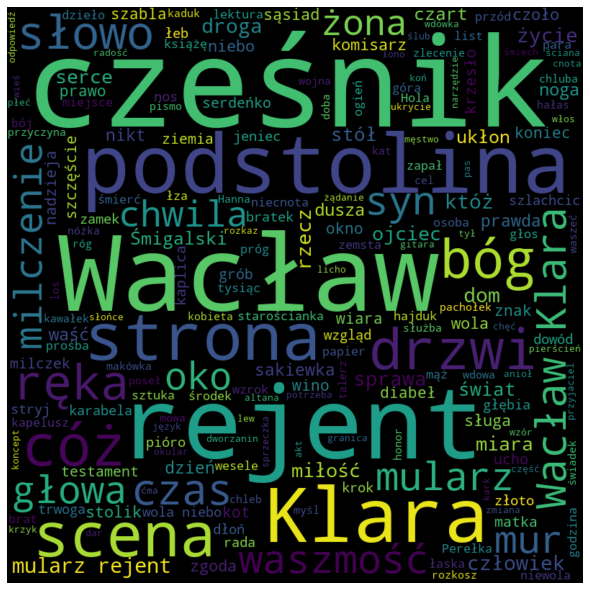

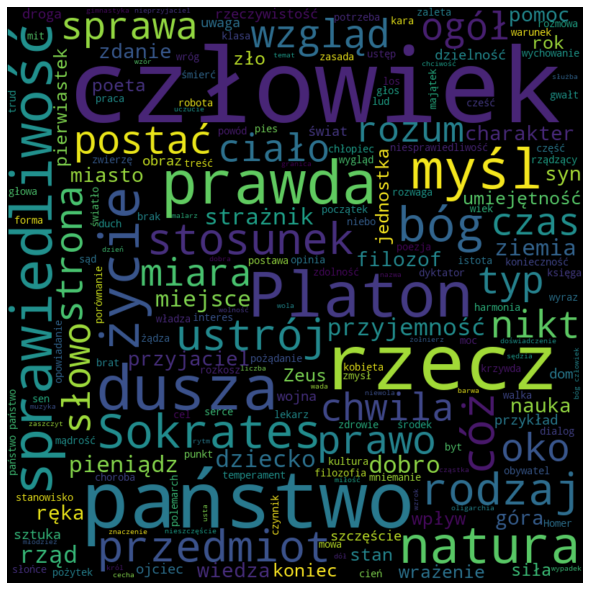

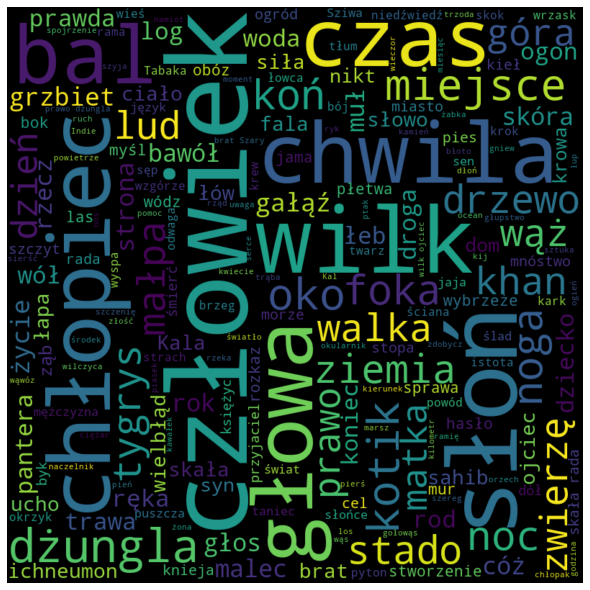

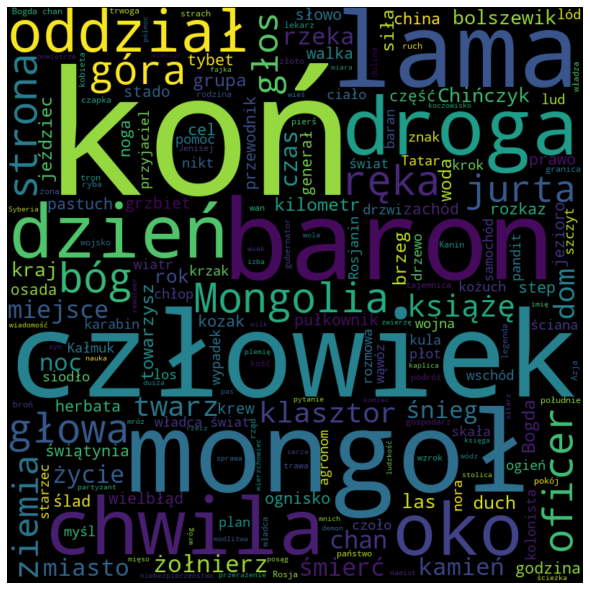

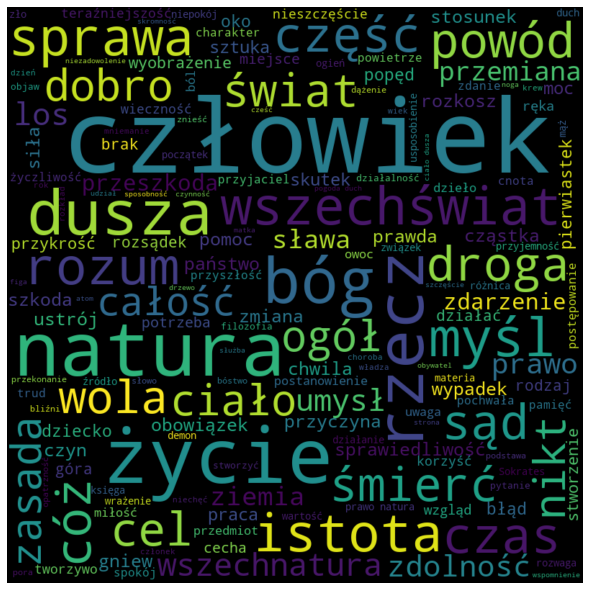

In [ ]:
# chmura tagów (wordcloud)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
with open('polish_stopwords', 'r') as f:
    sw = f.read().split()
sw = set(sw)

for doc in corpus:
  comment_words = ""
  for token in doc:
    if token.pos_ == 'NOUN':
      comment_words = " ".join((comment_words, token.lemma_))
  # obiekt wordcloud
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='black', 
                  stopwords = sw, 
                  min_font_size = 10).generate(comment_words) 
  # 'Wykres' chmury tagów                         
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud, interpolation='bilinear') 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show() 

In [ ]:
# 5. Przykłady  niejednoznaczności znaczeniowej  występujacej w tekstach 
# oraz przyjęty sposób ich rozwiązania 
t1 = '''Cześnik, także rozogniony,
        Jak gromnica ku niej pała —
        Będzie para doskonała.'''
t2 = '''Ja z nim w zgodzie? — Mocium panie,
        Wprzódy słońce w miejscu stanie!(...)
        W małżeństwie ciężko jest być w stanie spokoju'''

print(t1)
print("{0:15} {1:8} {2:6} {3:15}\n".format(".orth_", ".tag_", ".pos_", "._.feats"))
for token in nlp(t1):
  print("{0:15} {1:8} {2:6} {3:15}".format(token.orth_, token.tag_, token.pos_, token._.feats))
print(t2)
print("{0:15} {1:8} {2:6} {3:15}\n".format(".orth_", ".tag_", ".pos_", "._.feats"))
for token in nlp(t2):
  print("{0:15} {1:8} {2:6} {3:15}".format(token.orth_, token.tag_, token.pos_, token._.feats))

Cześnik, także rozogniony,
        Jak gromnica ku niej pała —
        Będzie para doskonała.
.orth_          .tag_    .pos_  ._.feats       

Cześnik         subst    NOUN   sg:nom:m1      
,               interp   PUNCT                 
także           qub      PART                  
rozogniony      adj      ADJ    sg:nom:m1:pos  
,               interp   PUNCT                 
Jak             adv      ADV    pos            
gromnica        subst    NOUN   sg:nom:f       
ku              prep     ADP    dat            
niej            ppron3   PRON   sg:dat:f:ter:akc:praep
pała            fin      VERB   sg:ter:imperf  
—               interp   PUNCT                 
Będzie          bedzie   VERB   sg:ter:imperf  
para            subst    NOUN   sg:nom:f       
doskonała       adj      ADJ    sg:nom:f:pos   
.               interp   PUNCT                 
Ja z nim w zgodzie? — Mocium panie,
        Wprzódy słońce w miejscu stanie!(...)
        W małżeństwie ciężko jest być w stanie s

Jako przykład rozwiązania niejednoznaczności znaczeniowej użyto fragmentów "Zemsty" z słowami "pała" oraz "stanie". Model spacy poprawnie zinterpretował, że dla danego w fragmencie kontekstu wyraz "pała", powinien być czasownikiem (od pałać - żywić silne uczucia), a nie rzeczownikiem np. para wodna.

W drugim fragmencie również poprawnie obliczył że pierwsze wystąpienie "stanie" odnosi się do czasownika (stawać), a drugie wystąpienie odnosi się do rzeczownika (stan).

In [ ]:
# 6*. W wybranej lekturze znaleźć 5 rzeczowników występujących w formie 
# podmiotów oraz pokazać z jakimi czasownikami się łączą 
# w związku podmiotu z orzeczeniem.
book = corpus[1]
selected_nouns = []
for token in book:
  if token.pos_ == 'NOUN' and token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
    selected_nouns.append(token.orth_ + " " + token.head.orth_)
  if len(selected_nouns) >= 5:
    break
# lista podmiotów z orzeczeniem
print(selected_nouns)

['autor uważa', 'Akcenty padają', 'To wygląda', 'człowiek pisał', 'Uczucie ponosi']
